this kernel is from 
https://www.kaggle.com/manojprabhaakr/similar-duplicate-images-in-aptos-data
and  https://www.kaggle.com/maxwell110/duplicated-list-csv-file/ 

I do three things:
1. change phash to md5 according see-'s comment https://www.kaggle.com/maxwell110/duplicated-list-csv-file/comments#575422;
2. Duplicated with different label
3. Duplicated in both train and test.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#print(os.listdir("../input"))
import sys;
import hashlib;
from os.path import isfile
from joblib import Parallel, delayed
import psutil

In [2]:
train_df = pd.read_csv("../data/train_old.csv")
print(train_df.shape)
test_df = pd.read_csv("../data/sample_submission.csv")
test_df['diagnosis'] = np.nan
train = train_df.append(test_df)

(35126, 2)


In [3]:
def expand_path(p):
    if isfile('../external_data/train_images/' + p + '.jpeg'): return '../external_data/train_images/' + p + '.jpeg'
#     if isfile('../external_data/test_images/' + p + '.png'): return '../input/test_images/' + p + '.png'
    return p
def getImageMetaData(p):
    strFile = expand_path(p)
    file = None;
    bRet = False;
    strMd5 = "";
    
    try:
        file = open(strFile, "rb");
        md5 = hashlib.md5();
        strRead = "";
        
        while True:
            strRead = file.read(8096);
            if not strRead:
                break;
            md5.update(strRead);
        #read file finish
        bRet = True;
        strMd5 = md5.hexdigest();
    except:
        bRet = False;
    finally:
        if file:
            file.close()

    return p,strMd5

In [4]:
img_meta_l = Parallel(n_jobs=psutil.cpu_count(), verbose=1)(
    (delayed(getImageMetaData)(fp) for fp in train.id_code))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  71 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 1271 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 3271 tasks      | elapsed:   25.0s
[Parallel(n_jobs=4)]: Done 5583 out of 5590 | elapsed:   33.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 5590 out of 5590 | elapsed:   33.3s finished


In [5]:
img_meta_df = pd.DataFrame(np.array(img_meta_l))
img_meta_df.columns = ['id_code', 'strMd5']

In [6]:
train = train.merge(img_meta_df,on='id_code')

In [7]:
train['strMd5_count'] = train.groupby('strMd5').id_code.transform('count')

In [8]:
train['strMd5_nunique'] = train.groupby('strMd5')['diagnosis'].transform('nunique').astype('int')

In [9]:
train[train.strMd5_count>1].strMd5_count.value_counts()

2    510
4     12
3      9
5      5
Name: strMd5_count, dtype: int64

In [10]:
import matplotlib.pyplot as plt
import cv2

**Duplicated with same label**

In [11]:
train[(train.strMd5_count>1)&(train.strMd5_nunique==1)].strMd5_count.value_counts()

2    446
3      6
5      5
4      4
Name: strMd5_count, dtype: int64

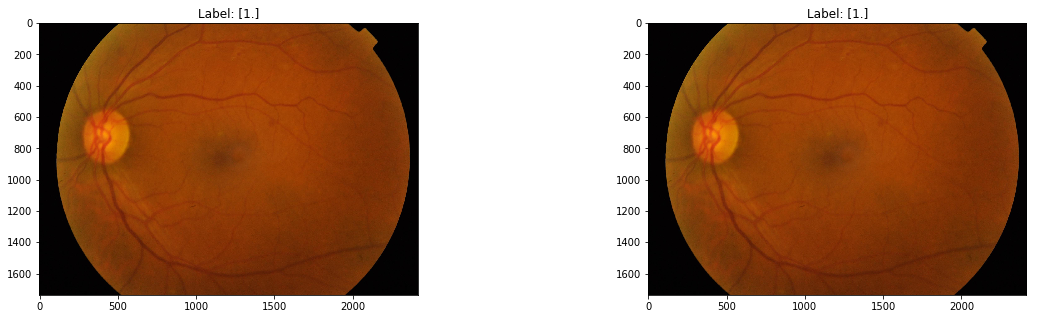

In [12]:
strMd51 = train[(train.strMd5_count>1)&(train.strMd5_nunique==1)].strMd5.unique()
strMd5 = strMd51[0]
size = len(train[train['strMd5'] == strMd5]['id_code'])
fig = plt.figure(figsize = (20, 5))
for idx, img_name in enumerate(train[train['strMd5'] == strMd5]['id_code'][:size]):
    y = fig.add_subplot(1, size, idx+1)
    img = cv2.imread(expand_path(img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    class_id = train[train.id_code==img_name]['diagnosis'].values
    y.set_title(f'Label: {class_id}')
    y.imshow(img)
plt.show()

**Duplicated with different label**

In [13]:
train[(train.strMd5_count>1)&(train.strMd5_nunique>1)].strMd5_count.value_counts()

2    54
4     8
3     3
Name: strMd5_count, dtype: int64

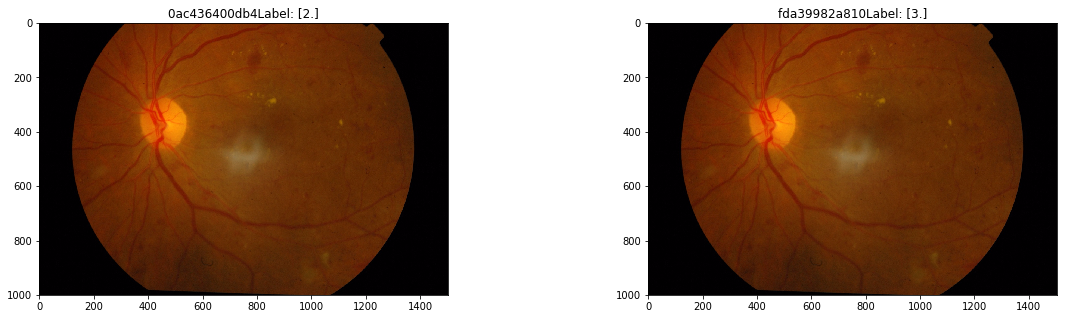

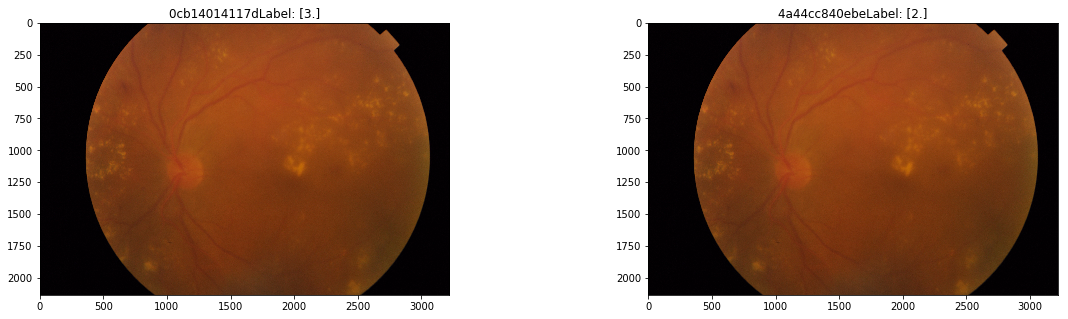

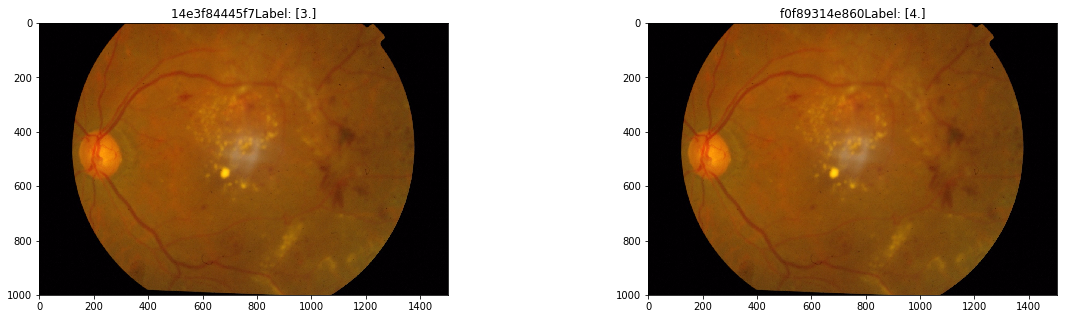

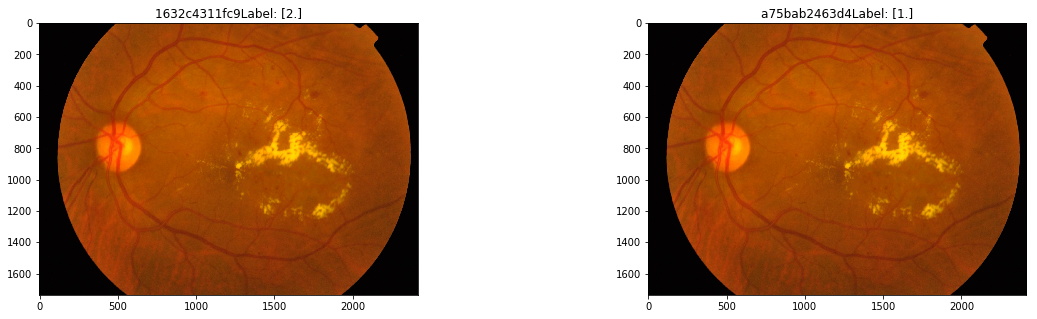

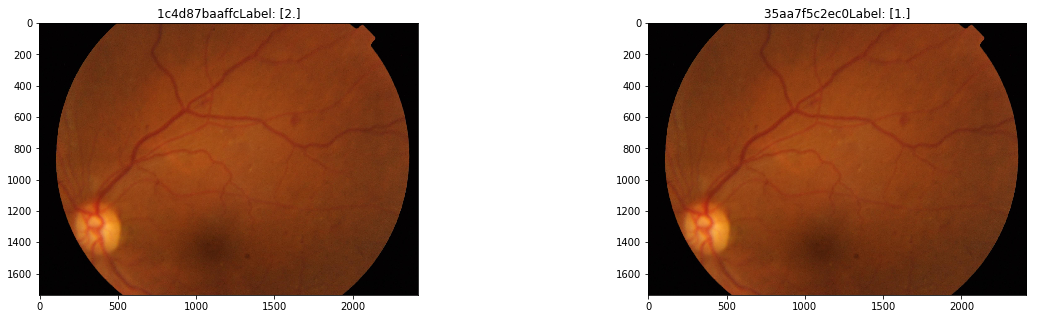

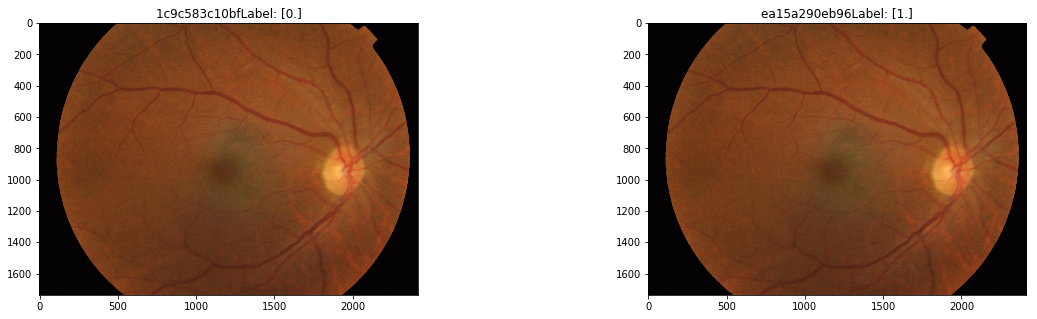

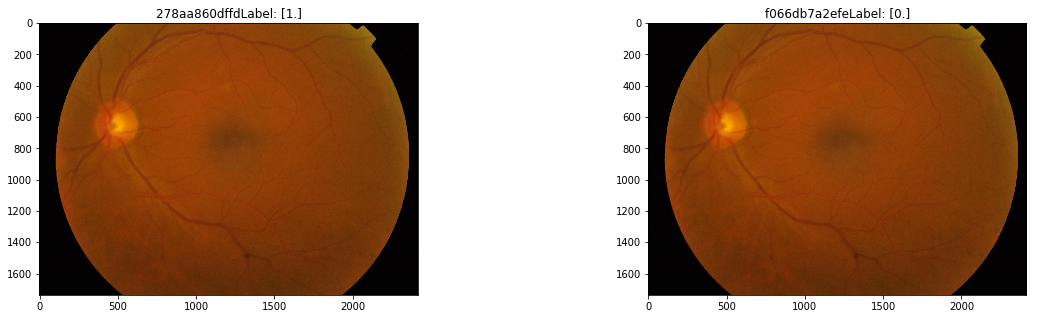

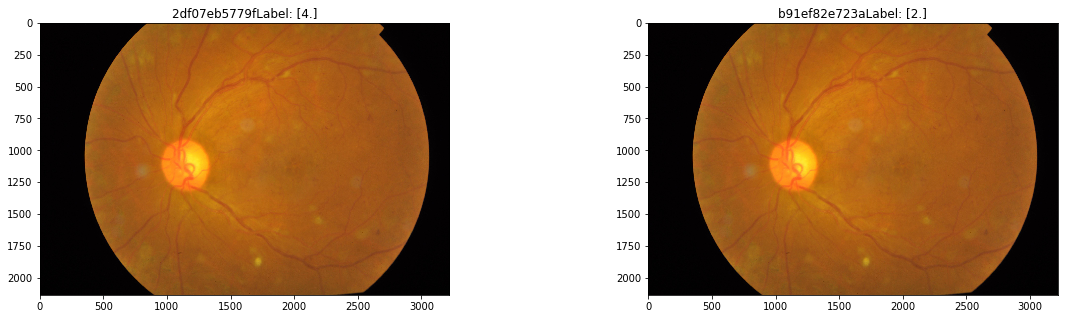

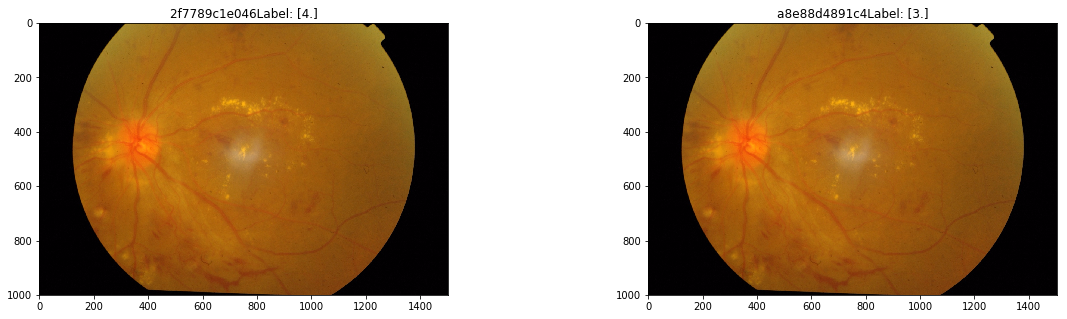

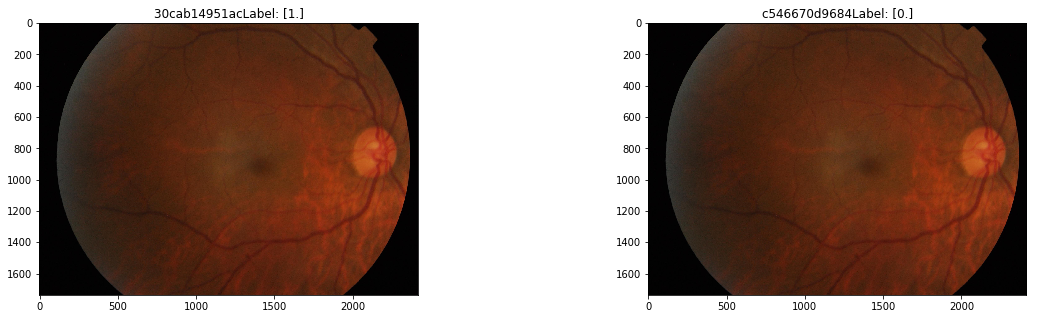

In [14]:
strMd52 = train[(train.strMd5_count>1)&(train.strMd5_nunique>1)].strMd5.unique()
strMd5 = strMd52[0]
for strMd5 in strMd52[:10]:
    size = len(train[train['strMd5'] == strMd5]['id_code'])
    fig = plt.figure(figsize = (20, 5))
    for idx, img_name in enumerate(train[train['strMd5'] == strMd5]['id_code'][:size]):
        y = fig.add_subplot(1, size, idx+1)
        img = cv2.imread(expand_path(img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        class_id = train[train.id_code==img_name]['diagnosis'].values
        y.set_title(img_name+f'Label: {class_id}')
        y.imshow(img)
    plt.show()

**Duplicated in both train and test**

In [15]:
train[(train.strMd5_count>1)&(train.diagnosis.isnull())].shape[0]

151

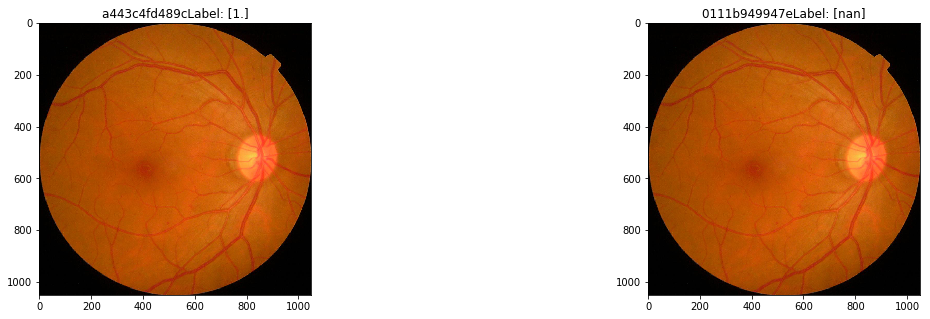

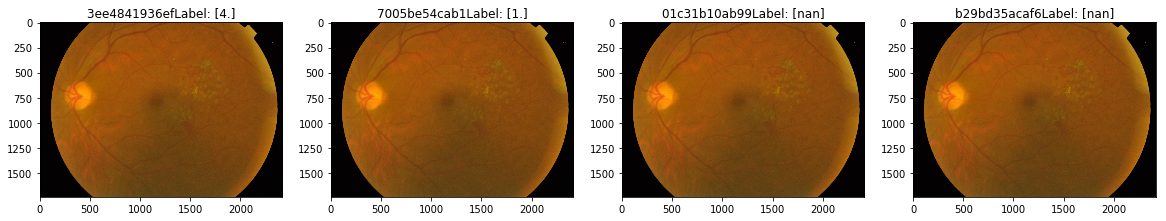

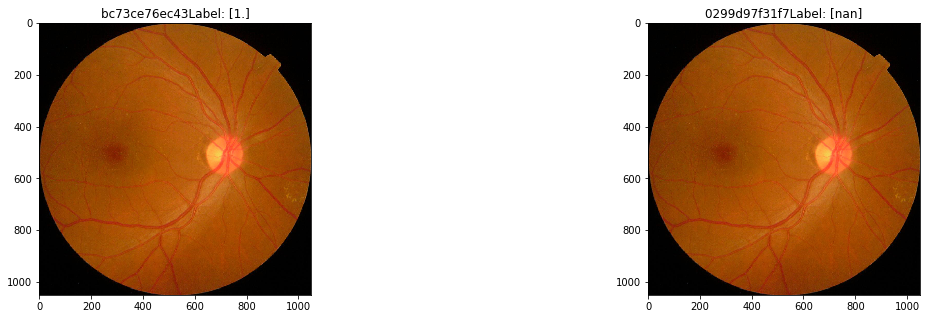

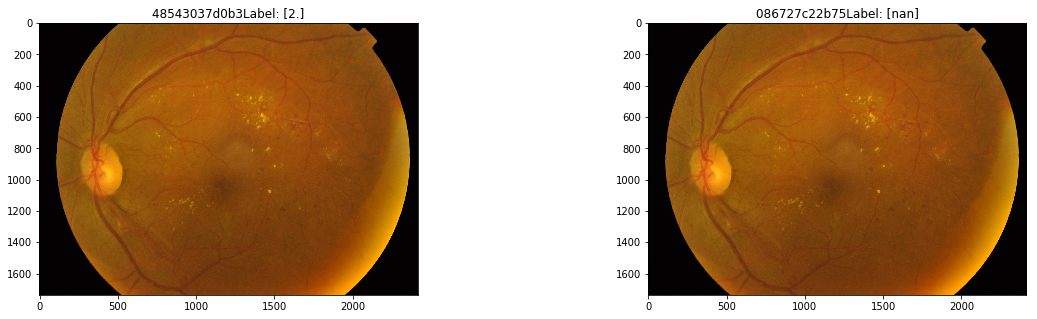

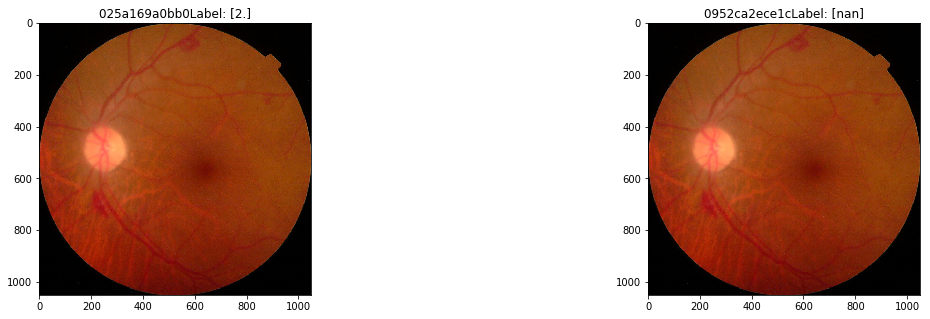

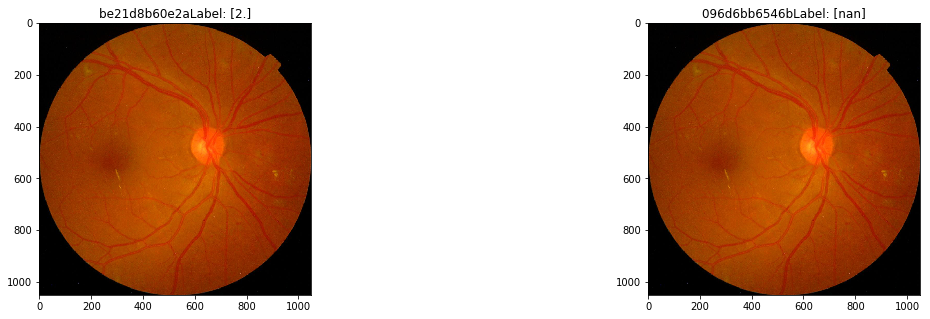

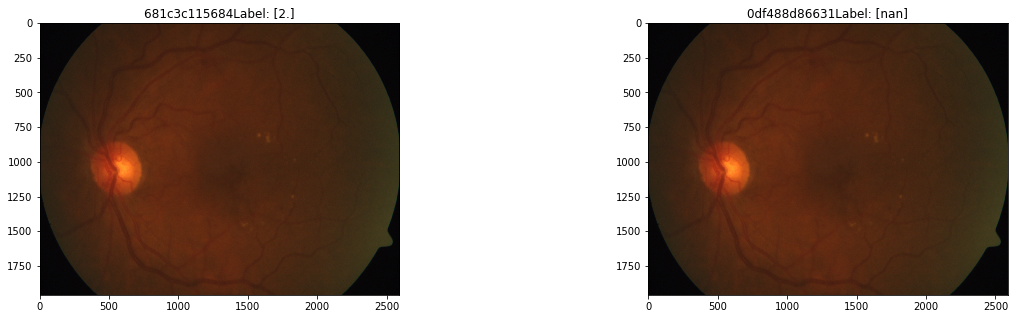

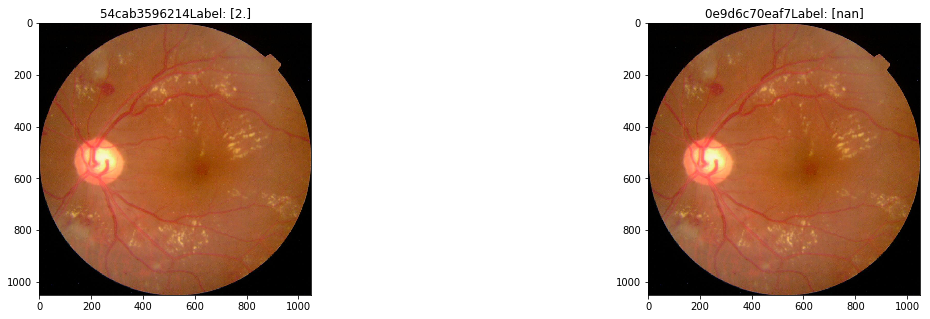

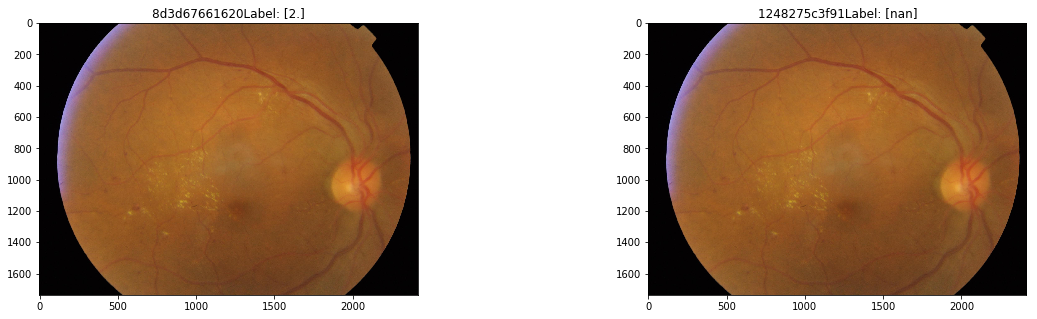

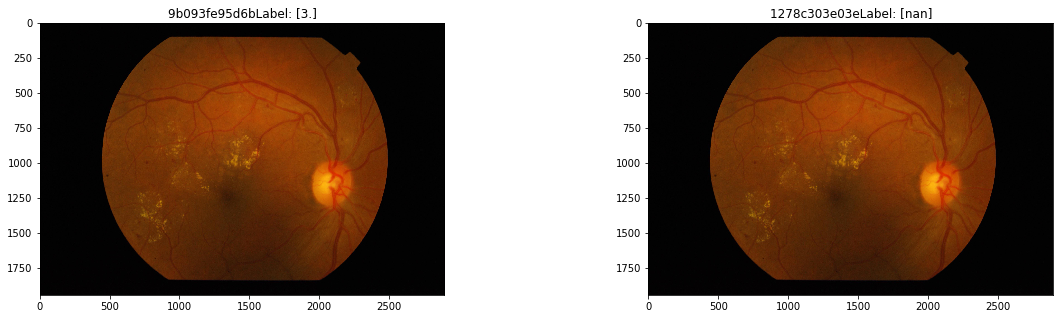

In [16]:
strMd52 = train[(train.strMd5_count>1)&(train.diagnosis.isnull())].strMd5.unique()
strMd5 = strMd52[0]
for strMd5 in strMd52[:10]:
    size = len(train[train['strMd5'] == strMd5]['id_code'])
    fig = plt.figure(figsize = (20, 5))
    for idx, img_name in enumerate(train[train['strMd5'] == strMd5]['id_code'][:size]):
        y = fig.add_subplot(1, size, idx+1)
        img = cv2.imread(expand_path(img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        class_id = train[train.id_code==img_name]['diagnosis'].values
        y.set_title(img_name+f'Label: {class_id}')
        y.imshow(img)
    plt.show()